In [1]:
import pandas as pd

In [2]:
#!pip install matplotlib==2.2.3.


In [3]:
import networkx as nx



In [4]:
df_op = pd.read_csv('../openpredict/data/input/openpredict-omim-drug.csv')


In [5]:
df_op = df_op.rename(columns={'omimid': 'disease_id', 'drugid': 'drug_id'})

In [6]:
df_op.disease_id = df_op.disease_id.astype(str)


In [7]:
indications_dict = set()
for i, row in df_op.iterrows():
    #row['DB_ID'], row['DO_ID']
    pair = (str(row['drug_id']), str(row['disease_id']))
    indications_dict.add(pair)
len(indications_dict)


1933

In [8]:

#!pip install gensim

In [9]:
from gensim.models import KeyedVectors


In [10]:
drug_fp_vectors = KeyedVectors.load_word2vec_format(
    '../openpredict/data/embedding/drugs_fp_embed.txt', binary=False)
disease_hp_vectors = KeyedVectors.load_word2vec_format(
    '../openpredict/data/embedding/disease_hp_embed.txt', binary=False)


In [100]:
# openpredict:most_similar('DB00570', 10)
def get_evidence_graph_for_pairs(drug, disease, drug_emb_vectors, disease_emb_vectors):
    g = nx.Graph()
    #g.add_edge(DRUGB[dr], OMIM[ds], weight=1)
    similarDrugs = drug_emb_vectors.most_similar(drug, topn=100)
    #print (similarDrugs)
    g.add_node("DrugBank:"+drug, id="DrugBank:"+drug,
               name="fake", categories=["biolink:Drug"])
    for dr, sim in similarDrugs:
        print(dr, ' ', drug, 1-sim)
        #g.add_edge(dr, drug, weight=1-sim)

        g.add_node("DrugBank:"+dr, id="DrugBank:"+dr,
                   name="fake", categories=["biolink:Drug"])
        g.add_edge("DrugBank:"+dr, "DrugBank:"+drug, id="DrugBank:"+dr+"_DrugBank: "+drug,
                   predicate="biolink:similar_to", subject="DrugBank:"+dr, object="DrugBank:"+drug,  weight=1-sim, attributes={"description": "score",
                                                               "attribute_type_id": "EDAM:data_1772",
                                                               "value": 1-sim
                                                               })
    g.add_node("OMIM:"+disease, id="OMIM:"+disease,
               name="fake", categories=["biolink:Disease"])
               
    similarDiseases = disease_emb_vectors.most_similar(disease, topn=100)
    for ds, sim in similarDiseases:
        print(ds, ' ', disease)
        #g.add_edge(ds, disease, weight=1-sim)
        g.add_node("OMIM:"+ds, id="OMIM:"+ds,
                   name="fake", categories=["biolink:Disease"])
        g.add_edge("OMIM:"+ds, "OMIM:"+disease,
                   id="OMIM:" + ds+"_OMIM:"+disease, predicate="biolink:similar_to", subject="OMIM:"+ds, object="OMIM:"+disease, weight=1-sim, attributes={"description": "score",
                                                                                                 "attribute_type_id": "EDAM:data_1772",
                                                                                                 "value": 1-sim
                                                                                                 })
                                                                                                 


    for (dr, ds) in indications_dict:
        if "DrugBank:"+dr in g.nodes() and "OMIM:"+ds in g.nodes():
            print(dr, ds, 1)
            #g.add_edge(dr, ds, weight=1)
            g.add_edge("DrugBank:"+dr, "OMIM:"+ds, id="DrugBank:" +
                       dr+"_OMIM:"+ds, predicate="biolink:treats", subject="DrugBank:"+dr, object="OMIM:"+ds,  weight=1, attributes={"description": "score",
                                                                               "attribute_type_id": "EDAM:data_1772",
                                                                               "value": "1.0"
                                                                               })
    return g


In [101]:
g1 = get_evidence_graph_for_pairs(
    'DB00570', '236000', drug_fp_vectors, disease_hp_vectors)


DB00572   DB00570 0.013681769371032715
DB00541   DB00570 0.02744448184967041
DB00584   DB00570 0.02816838026046753
DB00563   DB00570 0.02960383892059326
DB00590   DB00570 0.031969428062438965
DB00542   DB00570 0.035527944564819336
DB00557   DB00570 0.03574049472808838
DB00552   DB00570 0.03742796182632446
DB00611   DB00570 0.04217451810836792
DB00537   DB00570 0.045140206813812256
DB00530   DB00570 0.04641193151473999
DB00571   DB00570 0.048069119453430176
DB00521   DB00570 0.04973137378692627
DB00598   DB00570 0.049977660179138184
DB00593   DB00570 0.051826417446136475
DB00497   DB00570 0.052195847034454346
DB00583   DB00570 0.05246090888977051
DB00549   DB00570 0.05345219373703003
DB00519   DB00570 0.054671406745910645
DB00569   DB00570 0.054879188537597656
DB00585   DB00570 0.055013060569763184
DB00559   DB00570 0.05514037609100342
DB00545   DB00570 0.05730569362640381
DB00622   DB00570 0.05800461769104004
DB00502   DB00570 0.05813610553741455
DB00644   DB00570 0.06232762336730957
D

In [102]:
print("numbee of nodes",g1.number_of_nodes())
print("numbee of nodes", g1.number_of_edges())


numbee of nodes 202
numbee of nodes 336


In [103]:
g1.node['DrugBank:DB00572']


{'id': 'DrugBank:DB00572', 'name': 'fake', 'categories': ['biolink:Drug']}

In [104]:
length, path = nx.single_source_dijkstra(g1, 'DrugBank:DB00570', 'OMIM:236000')


In [105]:
#length, path = nx.single_source_dijkstra(g1, 'DrugBank:DB00570', 'OMIM:236000')
path_weight = {}
for path in nx.all_simple_paths(g1, 'DrugBank:DB00570', 'OMIM:236000', cutoff=5):
    #print (path)
    dpath = 0
    for i in range(len(path)-1):
        #print(g1[path[i]][path[i+1]])
        dpath += g1[path[i]][path[i+1]]['weight']
    path_weight[str(path)] = dpath


In [106]:
path_weight_dict = sorted(path_weight.items(), key=lambda x: x[1], )

In [107]:
path_weight_dict[:10]


[("['DrugBank:DB00570', 'OMIM:236000']", 1),
 ("['DrugBank:DB00570', 'DrugBank:DB00541', 'OMIM:236000']",
  1.0274444818496704),
 ("['DrugBank:DB00570', 'DrugBank:DB00563', 'OMIM:236000']",
  1.0296038389205933),
 ("['DrugBank:DB00570', 'DrugBank:DB00541', 'OMIM:254500', 'OMIM:236000']",
  1.0635769963264465),
 ("['DrugBank:DB00570', 'OMIM:148000', 'OMIM:236000']", 1.0775106549263),
 ("['DrugBank:DB00570', 'DrugBank:DB00444', 'OMIM:236000']",
  1.1103540658950806),
 ("['DrugBank:DB00570', 'DrugBank:DB00619', 'OMIM:131440', 'OMIM:236000']",
  1.1200258135795593),
 ("['DrugBank:DB00570', 'DrugBank:DB00541', 'OMIM:223350', 'OMIM:236000']",
  1.1201560497283936),
 ("['DrugBank:DB00570', 'DrugBank:DB00563', 'OMIM:223350', 'OMIM:236000']",
  1.1223154067993164),
 ("['DrugBank:DB00570', 'DrugBank:DB00480', 'OMIM:254500', 'OMIM:236000']",
  1.1275046467781067)]

In [108]:
import ast
G = nx.Graph()
for p, s in path_weight_dict[:10]:
    path = ast.literal_eval(p)
    print(path, s)
    for i in range(len(path)-1):
        print(path[i])
        s_node_name = path[i]
        t_node_name = path[i+1]
        edge_data = g1[s_node_name][t_node_name]
        #print(node_name)
        G.add_node(s_node_name, g1.node[s_node_name])
        G.add_node(t_node_name, g1.node[t_node_name])
        G.add_edge(s_node_name, t_node_name, edge_data)


['DrugBank:DB00570', 'OMIM:236000'] 1
DrugBank:DB00570
['DrugBank:DB00570', 'DrugBank:DB00541', 'OMIM:236000'] 1.0274444818496704
DrugBank:DB00570
DrugBank:DB00541
['DrugBank:DB00570', 'DrugBank:DB00563', 'OMIM:236000'] 1.0296038389205933
DrugBank:DB00570
DrugBank:DB00563
['DrugBank:DB00570', 'DrugBank:DB00541', 'OMIM:254500', 'OMIM:236000'] 1.0635769963264465
DrugBank:DB00570
DrugBank:DB00541
OMIM:254500
['DrugBank:DB00570', 'OMIM:148000', 'OMIM:236000'] 1.0775106549263
DrugBank:DB00570
OMIM:148000
['DrugBank:DB00570', 'DrugBank:DB00444', 'OMIM:236000'] 1.1103540658950806
DrugBank:DB00570
DrugBank:DB00444
['DrugBank:DB00570', 'DrugBank:DB00619', 'OMIM:131440', 'OMIM:236000'] 1.1200258135795593
DrugBank:DB00570
DrugBank:DB00619
OMIM:131440
['DrugBank:DB00570', 'DrugBank:DB00541', 'OMIM:223350', 'OMIM:236000'] 1.1201560497283936
DrugBank:DB00570
DrugBank:DB00541
OMIM:223350
['DrugBank:DB00570', 'DrugBank:DB00563', 'OMIM:223350', 'OMIM:236000'] 1.1223154067993164
DrugBank:DB00570
DrugBan

In [231]:
G.number_of_edges()

19

In [232]:
G.number_of_nodes()


11

In [236]:
G['DrugBank:DB00570']['OMIM:236000']


{'id': 'DrugBank:DB00570_OMIM:236000',
 'predicate': 'biolink:treats',
 'subject': 'DrugBank:DB00570',
 'object': 'OMIM:236000',
 'weight': 1,
 'attributes': {'description': 'score',
  'attribute_type_id': 'EDAM:data_1772',
  'value': '1.0'}}

In [237]:
G.node['DrugBank:DB00570']


{'id': 'DrugBank:DB00570', 'name': 'fake', 'categories': ['biolink:Drug']}

In [238]:
graph_json ={}

In [239]:

graph_json['nodes'] = list()
for node in G.nodes():
    #print (node)
    print(G.node[node])
    graph_json['nodes'].append(G.node[node])


{'id': 'DrugBank:DB00570', 'name': 'fake', 'categories': ['biolink:Drug']}
{'id': 'OMIM:236000', 'name': 'fake', 'categories': ['biolink:Disease']}
{'id': 'DrugBank:DB00541', 'name': 'fake', 'categories': ['biolink:Drug']}
{'id': 'DrugBank:DB00563', 'name': 'fake', 'categories': ['biolink:Drug']}
{'id': 'OMIM:254500', 'name': 'fake', 'categories': ['biolink:Disease']}
{'id': 'OMIM:148000', 'name': 'fake', 'categories': ['biolink:Disease']}
{'id': 'DrugBank:DB00444', 'name': 'fake', 'categories': ['biolink:Drug']}
{'id': 'DrugBank:DB00619', 'name': 'fake', 'categories': ['biolink:Drug']}
{'id': 'OMIM:131440', 'name': 'fake', 'categories': ['biolink:Disease']}
{'id': 'OMIM:223350', 'name': 'fake', 'categories': ['biolink:Disease']}
{'id': 'DrugBank:DB00480', 'name': 'fake', 'categories': ['biolink:Drug']}


In [240]:

graph_json['edges']=list()
for edge in G.edges():
    #print (edge)
    #print(G[edge[0]][edge[1]], type(G[edge[0]][edge[1]]))
    graph_json['edges'].append(G[edge[0]][edge[1]])


In [241]:
graph_json

{'nodes': [{'id': 'DrugBank:DB00570',
   'name': 'fake',
   'categories': ['biolink:Drug']},
  {'id': 'OMIM:236000', 'name': 'fake', 'categories': ['biolink:Disease']},
  {'id': 'DrugBank:DB00541', 'name': 'fake', 'categories': ['biolink:Drug']},
  {'id': 'DrugBank:DB00563', 'name': 'fake', 'categories': ['biolink:Drug']},
  {'id': 'OMIM:254500', 'name': 'fake', 'categories': ['biolink:Disease']},
  {'id': 'OMIM:148000', 'name': 'fake', 'categories': ['biolink:Disease']},
  {'id': 'DrugBank:DB00444', 'name': 'fake', 'categories': ['biolink:Drug']},
  {'id': 'DrugBank:DB00619', 'name': 'fake', 'categories': ['biolink:Drug']},
  {'id': 'OMIM:131440', 'name': 'fake', 'categories': ['biolink:Disease']},
  {'id': 'OMIM:223350', 'name': 'fake', 'categories': ['biolink:Disease']},
  {'id': 'DrugBank:DB00480', 'name': 'fake', 'categories': ['biolink:Drug']}],
 'edges': [{'id': 'DrugBank:DB00570_OMIM:236000',
   'predicate': 'biolink:treats',
   'subject': 'DrugBank:DB00570',
   'object': 'OMIM

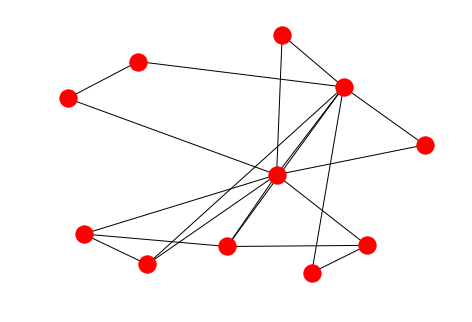

In [244]:
import matplotlib.pyplot as plt
#G = nx.dodecahedral_graph()
#nx.draw(G)  # networkx draw()
#plt.draw()  # pyplot draw()
#plt.show()

options = {
    "font_size": 36,
    "node_size": 3000,
    "node_color": "white",
    "edgecolors": "black",
    "linewidths": 5,
    "width": 5,
}
nx.draw(G, pos=nx.spring_layout(G))
plt.draw()
